# Fine-tuning Transformer models for Sequence Classification task

*Note If use this notebook in Google Colab please upload all the data and indicate the path.*

In [ ]:
%pip install transformers==4.29.2
%pip install onnx==1.12.0
%pip install onnxruntime==1.12.0
%pip install pytorch-lightning==1.6.0
%pip install netcal==1.3.5

## Import packages

In [ ]:
import json
import logging
import os
import sys
from typing import Any, Dict, List, NoReturn, Optional, Tuple, Union

import pandas as pd
import pytorch_lightning as pl
import torch
import torch.onnx
from torch.nn.functional import softmax
from torch.optim.lr_scheduler import LinearLR, LRScheduler
from torch.utils.data import DataLoader
from transformers import (
      AdamW,
      AutoConfig,
      AutoModelForSequenceClassification,
      AutoTokenizer,
    )
from transformers.modeling_outputs import SequenceClassifierOutput

logging.getLogger().setLevel(logging.INFO)
torch.set_printoptions(threshold=100000, linewidth=10000, precision=3, sci_mode=False)

## Compute metrics function

In [ ]:
def compute_metrics(output_df: pd.DataFrame) -> NoReturn:
    from netcal.metrics import ECE
    from netcal.presentation import ReliabilityDiagram
    from sklearn.metrics import classification_report
    import matplotlib.pyplot as plt
    import numpy as np

    # Measure calibration error by given predictions
    # with confidence and the according ground truth.
    n_bins = 10
    ece = ECE(n_bins)
    y_prob = np.array(output_df.predicted_softmax_dist.values.tolist())
    y_true = output_df.class_id.values
    ece_val = ece.measure(y_prob, y_true)
    logging.info(f"ECE: {ece_val}")

    # Plot Reliability diagram
    diagram = ReliabilityDiagram(n_bins)
    diagram.plot(y_prob, y_true)
    plt.savefig("ReliabilityDiagram.pdf")

    # Compute precision, recall, f1 metrics
    metrics_str = classification_report(
        output_df.predictions,
        output_df.labels,
        zero_division=0,
    )
    logging.info(f"* ML class-wise metrics *")
    logging.info(f"\n{metrics_str}")
    logging.info(f"------------------")

## Define Pytorch Dataset Class

In [ ]:
###################################
# Define Pytorch Dataset
###################################

from torch.utils.data import Dataset
from transformers import BatchEncoding


class ClassifierDataset(Dataset):
    def __init__(
        self,
        encodings: BatchEncoding,
        labels: Optional[List[int]] = None,
        uuid: Optional[List[str]] = None,
    ):
        self.encodings = encodings
        self.labels = labels
        if uuid:
            self.uuid = uuid

    def __getitem__(self, idx: int) -> Dict[str, Any]:
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        if "uuid" in self.__dict__:
            item["uuid"] = self.uuid[idx]
        return item

    def __len__(self) -> int:
        return len(self.labels)


## Define Data Module that is responsible for Text Tokenization and Dataset creation

In [ ]:
###################################
# Define DataModule
###################################
from transformers import PretrainedConfig


class DataModule:
    def __init__(
        self,
        conf: PretrainedConfig,
        model_params: Dict[str, Any],
        data_params: Dict[str, Any],
        **kwargs: Dict[str, Any],
    ):
        """
        This class provides Pytorch dataset for train, val, test splits
        """
        train_df = data_params.get("train_df", None)
        val_df = data_params.get("val_df", None)
        test_df = data_params.get("test_df", None)
        if (train_df is None or val_df is None) or (test_df is None):
            raise TypeError("Train and Val set OR Test set should be DataFrame.")

        self.conf = conf
        self.model_arch = model_params["model_arch"]
        self.only_evaluate = kwargs.get("only_evaluate", False)
        self.tokenizer = self.get_tokenizer()

        # Prepare train and val datasets
        if (train_df is not None) and (val_df is not None):
            self.train_dataset = self.create_dataset(train_df)
            self.val_dataset = self.create_dataset(val_df)

        # Prepare test dataset
        if test_df is not None:
            self.test_dataset = self.create_dataset(test_df)

    def get_tokenizer(self) -> AutoTokenizer:
        tokenizer = AutoTokenizer.from_pretrained(
            self.model_arch,
            config=self.conf,
            use_fast=True,
        )

        return tokenizer

    def create_dataset(self, df_data: pd.DataFrame, mode: str = "train") -> Dataset:
        # Sanity checks
        if mode not in ["train", "test"]:
            raise AttributeError(f"mode value: {mode} should be in ('train', 'test')")

        # Generate text labels
        if mode == "train":
            labels = list(
                df_data.apply(
                    lambda x: self.conf.label2id[x.label],
                    axis=1,
                )
            )
        else:
            labels = None

        # Tokenize the input text and create encodings
        data = df_data.to_dict("list")
        encodings = self.tokenizer(
            data["text"],
            is_split_into_words=False,
            padding=True,
            truncation=True,
        )

        # Create Pytorch datasets
        dataset = ClassifierDataset(
            encodings,
            labels=labels,
            uuid=data["uuid"],
        )

        return dataset


## Transformer training class implemented in PyTorch Lightning

In [ ]:
###############################################
# Classifier Trainer class
###############################################

# Decorator to skip running methods on test phase
def skip_on_test(method):
    def inner(ref):
        if ref.trainer.testing:
            return None
        return method(ref)

    return inner


class ClassifierFineTuner(pl.LightningModule):
    def __init__(
        self,
        model_params: Dict[str, Any],
        data_params: Dict[str, Any],
        **kwargs: Dict[str, Any],
    ):
        """Class to fine tune a Transformer based model on classifier tasks
        :param model_params: dict of model related parameters
        :param data_params: dict of data related parameters.
        :param saved_data_module_path: Path for saved data_module object.

        Other parameters will be in **kwargs:
        .. note::
            When used distributed data parallel, the batch size and the number of
            workers are specified on a per process basis. Therefore, the total batch
            size is calculated as the product of the number of GPUs with the batch size.
        """
        super().__init__()
        # Model related parameters
        self.model_arch = model_params.get("model_arch", "sentence-transformers/all-mpnet-base-v2")
        self.output_model_dir = model_params.get("output_model_dir", "all-mpnet-base-v2-tuned")
        self.weight_decay = model_params.get("weight_decay", 0.001)
        self.learning_rate = model_params.get("learning_rate", 5e-5)
        self.num_warmup_epochs = model_params.get("num_warmup_steps", 0)
        self.precision = model_params.get("precision", 32)

        # Read unique classes form csv file
        classifier_labels_path = data_params.get("classifier_labels_path")
        self.unique_labels = pd.read_csv(classifier_labels_path, header=None)[0].values.tolist()

        # Other parameters
        self.num_workers = data_params.get("num_workers", 0)
        self.only_evaluate = kwargs.get("only_evaluate", False)

        # Set random seed (always good to use for fair comparison of experiments)
        # Note must set random seed when using DDP training for correct usage
        seed = kwargs.get("seed", 42)
        pl.seed_everything(seed)

        # Load model
        self.model, self.conf = self.load_model(self.model_arch)

        # Create data module
        self.data_module = DataModule(self.conf, model_params, data_params, **kwargs)

    def load_model(self, model_arch: str) -> Tuple[AutoModelForSequenceClassification, AutoConfig]:
        # Load and update config
        conf = AutoConfig.from_pretrained(model_arch)
        conf.unique_labels = self.unique_labels

        # Obtain id-label mapping and load model
        if self.only_evaluate:
            # Load the model
            model = AutoModelForSequenceClassification.from_pretrained(
                model_arch,
                ignore_mismatched_sizes=False,
                config=conf,
            )
            # Obtain id2label and label2id maps
            self.id2label, self.label2id = model.config.id2label, model.config.label2id
        else:
            conf.num_labels = len(self.unique_labels)
            # Generate id2label amd label2id maps
            self.id2label = {i: x for i, x in enumerate(self.unique_labels)}
            self.label2id = {x: i for i, x in enumerate(self.unique_labels)}
            conf.id2label, conf.label2id = self.id2label, self.label2id
            # Load model

            model = AutoModelForSequenceClassification.from_pretrained(
                model_arch,
                ignore_mismatched_sizes=True,
                config=conf,
            )

        return model, conf

    def configure_optimizers(self) -> Tuple[List[AdamW], List[dict]]:
        # Split weights in two groups, one with weight decay and the other not.
        no_decay = ["bias", "LayerNorm.weight"]
        optimizer_grouped_parameters = [
            {
                "params": [p for n, p in self.model.named_parameters() if not any(nd in n for nd in no_decay)],
                "weight_decay": self.weight_decay,
            },
            {
                "params": [p for n, p in self.model.named_parameters() if any(nd in n for nd in no_decay)],
                "weight_decay": 0.0,
            },
        ]
        # Set optimizer
        optim = AdamW(optimizer_grouped_parameters, lr=self.learning_rate)
        # Set learning rate scheduler
        if self.num_warmup_epochs > 0:
            num_warmup_steps = int(len(self.train_loader) * self.num_warmup_epochs)
        else:
            num_warmup_steps = 1
        scheduler = {
            "scheduler": LinearLR(optim, total_iters=num_warmup_steps),
            "interval": "step",
            "frequency": 1,
        }

        return [optim], [scheduler]

    def lr_scheduler_step(self, scheduler: LRScheduler, *args) -> NoReturn:
        scheduler.step(epoch=self.current_epoch)

    def forward(
        self,
        input_ids: torch.Tensor,
        attention_mask: torch.Tensor,
        labels: Union[None, torch.Tensor] = None,
    ) -> SequenceClassifierOutput:
        outputs = self.model(input_ids, attention_mask=attention_mask, labels=labels)

        return outputs

    def training_step(self, batch: Dict[str, Any], batch_idx: int) -> Dict[str, torch.Tensor]:
        # Forward pass
        outputs = self.forward(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            labels=batch["labels"],
        )
        preds = torch.argmax(outputs.logits, dim=-1)

        return {"loss": outputs.loss, "preds": preds, "labels": batch["labels"]}

    def validation_step(self, batch: Dict[str, Any], batch_idx: int) -> Dict[str, torch.Tensor]:
        # Forward pass
        outputs = self.forward(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            labels=batch["labels"],
        )
        preds = torch.argmax(outputs.logits, dim=-1)

        return {"loss": outputs.loss, "preds": preds, "labels": batch["labels"]}

    def test_step(self, batch: Dict[str, Any], batch_idx: int) -> Tuple[Dict[str, Any], torch.Tensor]:
        outputs = self.forward(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])

        return batch, outputs

    # Called when training step ends
    def training_step_end(self, training_step_outputs: Dict[str, torch.Tensor]) -> NoReturn:
        self._update_metrics(training_step_outputs, self.metrics_train, "train")

    # Called when validation step ends
    def validation_step_end(self, val_step_outputs: Dict[str, torch.Tensor]) -> NoReturn:
        self._update_metrics(val_step_outputs, self.metrics_val, "val")

    # Called when test step ends
    def test_step_end(self, test_step_outputs: Tuple[Dict[str, Any], torch.Tensor]) -> NoReturn:
        """
        Obtain predicted labels, confidence and pack data in DataFrame
        """
        batch, outputs = test_step_outputs
        # Form labels lists
        labels = [self.conf.id2label[x] for x in batch["labels"].tolist()]
        # Get softmax distribution
        softmax_dist = softmax(outputs.logits, dim=1).cpu()
        # Get the predicted class and its probability
        predicted_probability, predicted_class_id = torch.max(softmax_dist, dim=1)
        predicted_probability, predicted_class_id = predicted_probability.tolist(), predicted_class_id.tolist()
        predictions = [self.conf.id2label[x] for x in predicted_class_id]
        # Save data into dict
        data = dict(
            uuid=batch["uuid"],
            predictions=predictions,
            predicted_probability=predicted_probability,
            predicted_softmax_dist=softmax_dist.tolist(),
            predicted_class_id=predicted_class_id,
            labels=labels,
            class_id=batch["labels"].tolist(),
        )
        # Updated resulted DataFrame
        data_step = pd.DataFrame.from_dict(data, orient="index").transpose()
        self.output_df = pd.concat([self.output_df, data_step])

    # Called when either of train/val/test epoch begins
    @skip_on_test
    def on_epoch_start(self) -> NoReturn:
        metrics = dict(
            running_loss=0,
            running_corrects=0,
            running_count=0,
            running_tp={label: 0 for label in self.conf.unique_labels},
            running_fp={label: 0 for label in self.conf.unique_labels},
            occurrences={label: 0 for label in self.conf.unique_labels},
        )
        phase = "train" if self.training else "val"
        if phase == "train":
            self.metrics_train = metrics
        else:
            self.metrics_val = metrics

    # Called when either of train/val/test epoch ends
    @skip_on_test
    def on_epoch_end(self) -> Tuple[dict, str, str]:
        epoch = self.current_epoch
        phase = "train" if self.training else "val"
        metrics = self.metrics_train if phase == "train" else self.metrics_val
        logging.info("EPOCH-{}  {}:".format(epoch, phase.upper()))

        # Logging class-wise metrics
        self._log_class_wise_metrics(metrics, phase, epoch)

        # Logging epoch-wise metrics
        epoch_loss = self.trainer.logged_metrics["loss/{}_epoch".format(phase)].item()
        epoch_acc = metrics["running_corrects"] / metrics["running_count"]
        logging_str = "{} Loss: {:.4f} Acc: {:.4f} ".format(phase, epoch_loss, epoch_acc)
        logging.info(logging_str)
        logging.info("----------------------------------------------------------------")

        return metrics, phase, logging_str

    def _log_class_wise_metrics(self, metrics: dict, phase: str, epoch: int) -> NoReturn:
        # Logging class-wise metrics
        for label in self.conf.unique_labels:
            tp = metrics["running_tp"][label]
            fp = metrics["running_fp"][label]
            occurrences = metrics["occurrences"][label]
            precision = tp / max(tp + fp, 1)
            recall = tp / max(occurrences, 1)
            logging.info(
                json.dumps(
                    {
                        "phase": phase,
                        "epoch": epoch,
                        "label": label,
                        "precision": precision.tolist(),
                        "recall": recall.tolist(),
                        "occurrences": occurrences.tolist(),
                        "global_rank": str(self.global_rank),
                    }
                )
            )

    # Update logging metrics
    def _update_metrics(self, outputs: Dict[str, torch.Tensor], metrics: dict, phase: str) -> NoReturn:
        preds = outputs["preds"]
        labels = outputs["labels"]
        metrics["running_count"] += len(preds)
        metrics["running_loss"] += outputs["loss"].item() * len(preds)
        metrics["running_corrects"] += torch.sum(preds == labels)

        for label, id_of_label in self.conf.label2id.items():
            mask_label = labels.data == id_of_label
            metrics["running_tp"][label] += torch.sum(preds[mask_label] == id_of_label)
            metrics["running_fp"][label] += torch.sum(preds[~mask_label] == id_of_label)
            metrics["occurrences"][label] += torch.sum(mask_label)

        # Logging loss
        self.log(
            "loss/{}".format(phase),
            outputs["loss"].item(),
            on_step=True,
            on_epoch=True,
            batch_size=self.batch_size,
        )

    # Run Transformer fine tuning
    def fine_tune(
        self,
        epochs_num: int = 10,
        batch_size: int = 16,
        shuffle_train_data: Optional[bool] = True,
    ) -> NoReturn:
        self.batch_size, self.epochs_num = batch_size, epochs_num
        # Create data loaders
        self.train_loader = DataLoader(
            self.data_module.train_dataset,
            batch_size=batch_size,
            num_workers=self.num_workers,
            shuffle=shuffle_train_data,
        )
        self.val_loader = DataLoader(
            self.data_module.val_dataset,
            batch_size=batch_size,
            num_workers=self.num_workers,
            shuffle=False,
        )
        logging.info(
            f"EPOCHS {type(epochs_num)} **"
            f"{len(self.train_loader)} **"
            f"{int(len(self.train_loader) * epochs_num)} **"
            f"{epochs_num} **"
            f"device {self.device}"
        )
        # Train on all available GPUs else use CPU
        num_gpus_avail = torch.cuda.device_count()
        trainer = pl.Trainer(
            max_epochs=epochs_num,
            accelerator="auto",
            enable_progress_bar=False,
            precision=self.precision,
            enable_checkpointing=False,
        )
        trainer.fit(self, self.train_loader, self.val_loader)
        logging.info("trainer.fit completed")

        # Close process if not main
        if self.global_rank != 0:
            sys.exit(0)

        # Save Pytorch trained model and tokenizer
        self.model.eval()
        self.model.save_pretrained(self.output_model_dir)
        self.data_module.tokenizer.save_pretrained(os.path.join(self.output_model_dir, "tokenizer"))
        # Save uuid of samples used to train current model
        pd.DataFrame({"training_uuid": self.data_module.train_dataset.uuid}).to_csv(
            os.path.join(self.output_model_dir, "training_uuid.csv"),
            index=False,
        )

        # Example input data
        input_ids_sample = self.data_module.val_dataset[0]["input_ids"].unsqueeze(0)
        attention_mask_sample = self.data_module.val_dataset[0]["attention_mask"].unsqueeze(0)
        dynamic_axes = {
            "input_ids": {0: "batch_size", 1: "sequence_size"},
            "attention_mask": {0: "batch_size", 1: "sequence_size"},
            "output": {0: "batch_size", 1: "sequence_size"},
        }
        # Export the model to ONNX format
        onnx_model_path = os.path.join(self.output_model_dir, "model.onnx")
        torch.onnx.export(
            self.model,
            (input_ids_sample, attention_mask_sample),
            onnx_model_path,
            verbose=True,
            input_names=["input_ids", "attention_mask"],
            output_names=["output"],
            dynamic_axes=dynamic_axes,
            opset_version=12,
        )

        logging.info("Training is finished, model is saved!")

    # Evaluate trained Transformer
    def evaluate(self, batch_size: int = 14) -> pd.DataFrame:
        """
        Run evaluation on test dataset and return DataFrame with predictions
        """
        # Create empty DataFrame to store results
        self.output_df = pd.DataFrame([])

        # Define test Dataloader
        test_dataset = self.data_module.test_dataset
        test_loader = DataLoader(
            test_dataset,
            batch_size=batch_size,
            num_workers=self.num_workers,
            shuffle=False,
        )

        # Initialize trainer object and tun inference on test
        trainer = pl.Trainer(
            accelerator="auto",
            gpus=1 if torch.cuda.device_count() > 0 else 0,
            enable_progress_bar=False,
            logger=False,
        )
        trainer.test(self, dataloaders=test_loader)

        # Close process if not main
        if self.global_rank != 0:
            sys.exit(0)

        # Compute calibration metrics and precision, recall, f1
        compute_metrics(self.output_df)

        return self.output_df

## Run model fine tuning

In [ ]:
# Set parameters and run finetuning
output_model_dir = "sentence-transformers/all-mpnet-base-v2-tuned-epochs-20"
model_params = dict(
    model_arch="sentence-transformers/all-mpnet-base-v2",
    output_model_dir=output_model_dir,
)

train_data_path = "train_transformed.csv"
val_data_path = "val_transformed.csv"
test_data_path = "test_transformed.csv"
data_params = dict(
    train_df=pd.read_csv(train_data_path),
    val_df=pd.read_csv(val_data_path),
    test_df=pd.read_csv(test_data_path),
    classifier_labels_path="atis_labels.csv",
    num_workers=2,
)

ft = ClassifierFineTuner(
    model_params,
    data_params,
    only_evaluate=False,
)

ft.fine_tune(epochs_num=20, batch_size=64)

INFO:pytorch_lightning.utilities.seed:Global seed set to 42
Some weights of the model checkpoint at sentence-transformers/all-mpnet-base-v2 were not used when initializing MPNetForSequenceClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing MPNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MPNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/all-mpnet-base-v2 and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight', 'class

# Evaluation

## Run Evaluation on Test set

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/utilities.py:91: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True, used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:307: LightningDeprecationWarning: The `LightningModule.on_epoch_start` hook was deprecated in v1.6 and will be removed in v1.8. Please use `LightningModule.on_<train/validation/test>_epoch_start` instead.
  rank_zero_deprecation(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:307: LightningDeprecationWarning: The `L

(856, 7)


,uuid,predictions,predicted_probability,predicted_softmax_dist,predicted_class_id,labels,class_id
0,c28ee71d-8e0c-47e2-aab2-9ada62814b84,flight,0.998987,"[7.970746992214117e-06, 1.4408664355869405e-05...",13,flight,13
1,5c82bc6f-8a74-4ae7-b17b-26c9c98e2de5,airfare,0.994885,"[0.00037900597089901567, 2.2079990230849944e-0...",3,airfare,3
2,d5b820ea-e20c-4f31-a703-6b80bc5587e4,flight,0.998885,"[8.062090273597278e-06, 1.5333544070017524e-05...",13,flight,13
3,b060cc49-43fa-4955-8b56-8f664f4a2c2c,flight,0.998962,"[7.921744327177294e-06, 1.5186043128778692e-05...",13,flight,13
4,4c0127cd-69f0-4c23-9397-10ce5aad6fa8,flight,0.998964,"[8.048851668718271e-06, 1.4328268662211485e-05...",13,flight,13


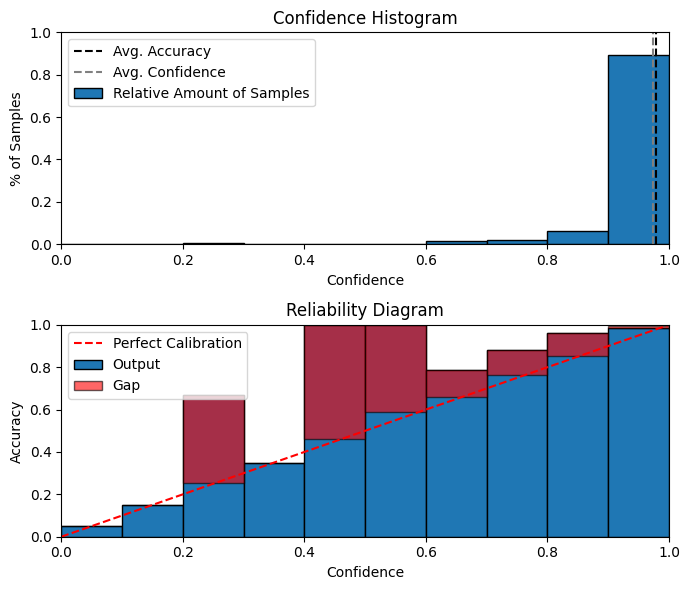

In [ ]:
df_preds = ft.evaluate(batch_size=16)

print(df_preds.shape)
df_preds.head(5)

In [ ]:
print("Accuracy: ", sum(df_preds.class_id == df_preds.predicted_class_id) / len(df_preds))

Accuracy:  0.977803738317757


### Check ONNX model

In [ ]:
import onnxruntime as ort
import numpy as np

# Load the ONNX model
session = ort.InferenceSession(os.path.join(output_model_dir, "model.onnx"))

# Example input data
input_ids_sample = ft.data_module.val_dataset[1]["input_ids"].unsqueeze(0).numpy()
attention_mask_sample = ft.data_module.val_dataset[1]["attention_mask"].unsqueeze(0).numpy()
# # Prepare input data as a dictionary
input_data = {
    'input_ids': input_ids_sample,
    'attention_mask': attention_mask_sample,
}

# Run inference
output_names = [output.name for output in session.get_outputs()]
outputs = session.run(output_names, input_data)
outputs

[array([[-2.8270962 , -2.186368  , -2.1588533 ,  0.61664057, -1.8665781 ,
         -0.9479774 , -2.4237556 , -1.9919989 , -3.037778  ,  0.01635226,
         -2.2472448 , -1.8079157 , -3.210104  ,  8.889921  , -0.03993854,
         -0.5144366 , -2.6527777 , -0.43734372, -4.803269  , -0.963966  ,
         -2.9282527 , -2.5436225 , -1.0697715 , -3.3070931 ]],
       dtype=float32)]

## Run evaluation on Test set using ONNX model

In [ ]:
# Obtain id2label mapping
config_path = os.path.join(os.path.join(output_model_dir, "config.json"))
with open(config_path, "r") as fp:
    config = json.load(fp)

id2label =  {int(key): value for key, value in config["id2label"].items()}
label2id =  {key: int(value) for key, value in config["label2id"].items()}
print(id2label)
print(label2id)

{0: 'abbreviation', 1: 'aircraft', 2: 'aircraft+flight+flight_no', 3: 'airfare', 4: 'airfare+flight_time', 5: 'airline', 6: 'airline+flight_no', 7: 'airport', 8: 'capacity', 9: 'cheapest', 10: 'city', 11: 'day_name', 12: 'distance', 13: 'flight', 14: 'flight+airfare', 15: 'flight+airline', 16: 'flight_no', 17: 'flight_time', 18: 'ground_fare', 19: 'ground_service', 20: 'ground_service+ground_fare', 21: 'meal', 22: 'quantity', 23: 'restriction'}
{'abbreviation': 0, 'aircraft': 1, 'aircraft+flight+flight_no': 2, 'airfare': 3, 'airfare+flight_time': 4, 'airline': 5, 'airline+flight_no': 6, 'airport': 7, 'capacity': 8, 'cheapest': 9, 'city': 10, 'day_name': 11, 'distance': 12, 'flight': 13, 'flight+airfare': 14, 'flight+airline': 15, 'flight_no': 16, 'flight_time': 17, 'ground_fare': 18, 'ground_service': 19, 'ground_service+ground_fare': 20, 'meal': 21, 'quantity': 22, 'restriction': 23}


In [ ]:
# Load Tokenizer
tokenizer_path = os.path.join(output_model_dir, "tokenizer")
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path, config=output_model_dir)

# Form prediction DF with columns: uuid	predictions	predicted_probability	predicted_softmax_dist	predicted_class_id	labels	class_id
df_test = pd.read_csv(test_data_path)
data_list = []
for i, row in df_test.iterrows():
  # Generate input
  input = dict(tokenizer(row["text"], return_tensors="np"))
  output = session.run(output_names, input)
  logits = torch.Tensor(output[0])
  # Get softmax distribution
  predicted_softmax_dist = softmax(logits, dim=1)
  # Get the predicted class and its probability
  predicted_probability, predicted_class_id = torch.max(predicted_softmax_dist, dim=1)
  predictions = id2label[predicted_class_id.item()]

  data_sample = [
    row["uuid"],
    predictions,
    predicted_probability.item(),
    predicted_softmax_dist[0].tolist(),
    predicted_class_id.item(),
    row["label"],
    label2id[row["label"]],
    ]
  data_list.append(data_sample)

df_preds_onnx = pd.DataFrame(data_list, columns=[
    "uuid",
    "predictions",
    "predicted_probability",
    "predicted_softmax_dist",
    "predicted_class_id",
    "labels",
    "class_id",
])
# Save predictions in csv file
df_preds_onnx.to_csv("predictions_test_set_onnx.csv", index=False)

print(df_preds_onnx.shape)
df_preds_onnx.head(3)

(856, 7)


,uuid,predictions,predicted_probability,predicted_softmax_dist,predicted_class_id,labels,class_id
0,c28ee71d-8e0c-47e2-aab2-9ada62814b84,flight,0.998987,"[7.970746082719415e-06, 1.4408663446374703e-05...",13,flight,13
1,5c82bc6f-8a74-4ae7-b17b-26c9c98e2de5,airfare,0.994885,"[0.0003790057962760329, 2.2080010239733383e-05...",3,airfare,3
2,d5b820ea-e20c-4f31-a703-6b80bc5587e4,flight,0.998885,"[8.062104825512506e-06, 1.533354225102812e-05,...",13,flight,13


INFO:root:ECE: 0.02454302426880202
INFO:root:* ML class-wise metrics *
INFO:root:
                            precision    recall  f1-score   support

              abbreviation       1.00      0.96      0.98        27
                  aircraft       0.88      0.88      0.88         8
 aircraft+flight+flight_no       0.00      0.00      0.00         0
                   airfare       1.00      0.91      0.95        53
       airfare+flight_time       0.00      0.00      0.00         0
                   airline       1.00      1.00      1.00        28
         airline+flight_no       1.00      1.00      1.00         1
                   airport       1.00      0.93      0.96        14
                  capacity       1.00      1.00      1.00        21
                  cheapest       0.00      0.00      0.00         0
                      city       1.00      1.00      1.00         5
                  day_name       1.00      1.00      1.00         2
                  distance       

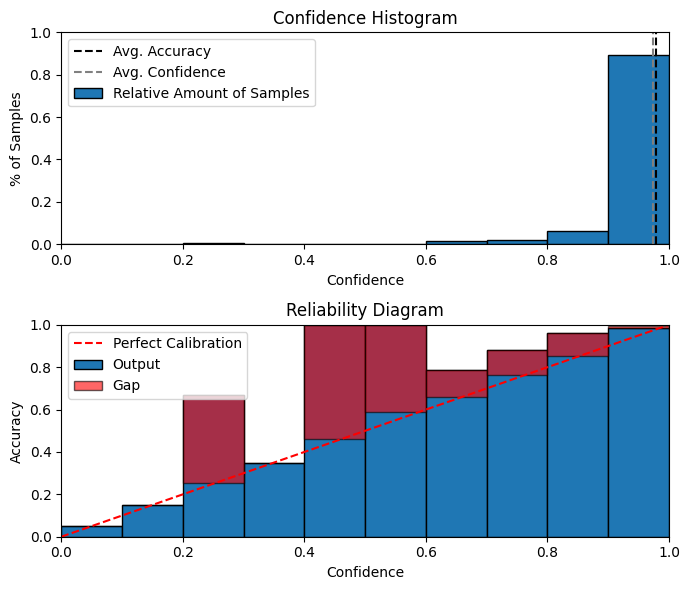

In [ ]:
# Compute calibration metrics and precision, recall, f1
compute_metrics(df_preds_onnx)

In [ ]:
print("Accuracy: ", sum(df_preds_onnx.class_id == df_preds_onnx.predicted_class_id) / len(df_preds_onnx))

Accuracy:  0.977803738317757


## Download model artifacts to local

In [ ]:
# # # Dowonload files to local
# from google.colab import files

# !zip -r sentence-transformers/all-mpnet-base-v2-tuned-epochs-20.zip sentence-transformers/all-mpnet-base-v2-tuned-epochs-20

# files.download("sentence-transformers/all-mpnet-base-v2-tuned-epochs-20.zip")

  adding: sentence-transformers/all-mpnet-base-v2-tuned-epochs-20/ (stored 0%)
  adding: sentence-transformers/all-mpnet-base-v2-tuned-epochs-20/training_uuid.csv (deflated 42%)
  adding: sentence-transformers/all-mpnet-base-v2-tuned-epochs-20/model.onnx (deflated 9%)
  adding: sentence-transformers/all-mpnet-base-v2-tuned-epochs-20/tokenizer/ (stored 0%)
  adding: sentence-transformers/all-mpnet-base-v2-tuned-epochs-20/tokenizer/tokenizer.json (deflated 71%)
  adding: sentence-transformers/all-mpnet-base-v2-tuned-epochs-20/tokenizer/special_tokens_map.json (deflated 50%)
  adding: sentence-transformers/all-mpnet-base-v2-tuned-epochs-20/tokenizer/tokenizer_config.json (deflated 49%)
  adding: sentence-transformers/all-mpnet-base-v2-tuned-epochs-20/tokenizer/vocab.txt (deflated 53%)
  adding: sentence-transformers/all-mpnet-base-v2-tuned-epochs-20/pytorch_model.bin (deflated 8%)
  adding: sentence-transformers/all-mpnet-base-v2-tuned-epochs-20/config.json (deflated 67%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>